In [21]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import os

from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas.tools.plotting import autocorrelation_plot

#from pyramid.arima import auto_arima
#from pmdarima.arima import auto_arima
import pyflux as pf
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [23]:
# single household contsumption data extract function
def extract_house(data_frame, lclid):
    df = data_frame.set_index("tstp")
    df.index = df.index.astype("datetime64")
    df = df[df["energy(kWh/hh)"] != "Null"]
    df["energy(kWh/hh)"] = df["energy(kWh/hh)"].astype("float64")
    df = df[df["LCLid"] == "{}".format(lclid) ]
    return df

In [24]:
# weather extraction function
def extract_weather(data_frame):
    df = data_frame.set_index("time")
    df.index = df.index.astype("datetime64")
    return df

In [172]:
# convert one to multiple series
def lag_ahead_series(data, n_in=1, n_out=1, n_vars = 1,dropnan=True):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for j in range(n_vars):
        for i in range(n_in, 0, -1):
            cols.append(df.iloc[:,j].shift(i))
            names.append('var{}(t-{})'.format(j+1, i))
    
    # forecast sequence (t+1, ... t+n)
    for j in range(n_vars):
        for i in range(0, n_out):
            cols.append(df.iloc[:,j].shift(-i))
            names += [('var{}(t+{})'.format(j+1, i)) ]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

**Processing csv document into energy consumption per housedhold per hour during the recorded period**

In [83]:
df = pd.read_csv("smart-meters-in-london/halfhourly_dataset/block_0.csv")
for num in range(1,111):    
    df = df.append(pd.read_csv("smart-meters-in-london/halfhourly_dataset/block_"+str(num)+".csv"))
        


In [86]:
df = df[df["energy(kWh/hh)"] != "Null"]
df["energy(kWh/hh)"] = df["energy(kWh/hh)"].astype("float64")

In [89]:
df = df.groupby('tstp').sum()

In [93]:
df.index = df.index.astype("datetime64")

In [95]:
df = df.resample('1H').sum()

In [201]:
df['tstp'] = df.index
df.tstp = df.tstp.astype("datetime64")

In [203]:
df.head(10)

,energy(kWh/hh),av_kWh/hh,tstp
tstp,,,
2011-11-23 09:00:00,1.130,NaN,2011-11-23 09:00:00
2011-11-23 10:00:00,1.508,NaN,2011-11-23 10:00:00
2011-11-23 11:00:00,2.123,NaN,2011-11-23 11:00:00
2011-11-23 12:00:00,6.589,NaN,2011-11-23 12:00:00
2011-11-23 13:00:00,6.263,NaN,2011-11-23 13:00:00
2011-11-23 14:00:00,6.184,NaN,2011-11-23 14:00:00
2011-11-23 15:00:00,4.902,NaN,2011-11-23 15:00:00
2011-11-23 16:00:00,4.867,NaN,2011-11-23 16:00:00
2011-11-23 17:00:00,6.169,NaN,2011-11-23 17:00:00


In [133]:
df['av_kWh'] = df["energy(kWh/hh)"]/housecount['LCLid']

In [220]:
#read in housecount to get average eneregy consumption
housecount = pd.read_csv("housecount.csv")
housecount.head(10)
housecount.index = housecount.day

housecount.index = housecount.index.astype("datetime64")


In [130]:
housecount.day = housecount.day.astype("datetime64")
housecount.day.dtypes
housecount.LCLid = housecount.LCLid.astype("float64")

In [222]:
housecount = housecount.resample('1H').pad()

In [224]:
df = df.join(housecount)

In [226]:
df['av_kWh/hh'] = df['energy(kWh/hh)']/df['LCLid']

In [228]:
energy = df.drop(['tstp','day','LCLid','energy(kWh/hh)'],axis = 1)

**Load in weather hourly data**

In [99]:
weather = pd.read_csv('smart-meters-in-london/weather_hourly_darksky.csv')

In [102]:
weather = extract_weather(weather)

In [109]:
weather = weather.drop(['precipType'],axis = 1)
weather = weather.drop(['icon'],axis = 1)


KeyError: "['precipType'] not found in axis"

In [110]:
##encoding summary
weather.summary=weather.summary.astype('category').cat.codes

In [111]:
weather.head(10)

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,summary
time,,,,,,,,,
2011-11-11 00:00:00,5.97,104,10.24,8.86,1016.76,10.24,2.77,0.91,8
2011-11-11 01:00:00,4.88,99,9.76,8.83,1016.63,8.24,2.95,0.94,8
2011-11-11 02:00:00,3.70,98,9.46,8.79,1016.36,7.76,3.17,0.96,8
2011-11-11 03:00:00,3.12,99,9.23,8.63,1016.28,7.44,3.25,0.96,5
2011-11-11 04:00:00,1.85,111,9.26,9.21,1015.98,7.24,3.70,1.00,5
2011-11-11 05:00:00,1.96,115,9.33,8.87,1015.91,7.19,3.97,0.97,5
2011-11-11 06:00:00,1.30,118,9.31,8.82,1015.70,7.10,4.10,0.97,5
2011-11-11 07:00:00,1.22,114,8.85,8.69,1016.08,6.48,4.23,0.99,5
2011-11-11 08:00:00,1.40,120,9.13,8.75,1016.33,6.84,4.20,0.97,5


In [231]:
weather_energy = weather.merge(energy, left_index = True, right_index = True)

In [261]:
weather_energy = pd.read_csv("whh.csv")

In [152]:
weather_energy.head(10)

,Unnamed: 0,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,summary,av_kWh/hh
0,2011-12-11 00:00:00,12.50,210,2.83,1.17,1015.67,1.11,1.78,0.89,8,0.495915
1,2011-12-11 01:00:00,12.65,204,2.48,0.81,1014.96,0.31,2.11,0.89,4,0.443318
2,2011-12-11 02:00:00,13.02,214,2.70,1.29,1014.42,0.11,2.57,0.90,4,0.347353
3,2011-12-11 03:00:00,13.05,211,3.47,1.41,1013.78,0.66,3.00,0.86,8,0.315408
4,2011-12-11 04:00:00,12.97,204,3.74,1.53,1012.94,1.29,2.64,0.85,8,0.278582
5,2011-12-11 05:00:00,12.68,201,4.23,2.48,1012.42,1.82,2.70,0.88,6,0.297687
6,2011-12-11 06:00:00,12.54,199,5.16,3.01,1011.74,3.03,2.57,0.86,6,0.334428
7,2011-12-11 07:00:00,12.50,198,4.98,3.13,1011.26,2.39,3.12,0.88,8,0.335080
8,2011-12-11 08:00:00,12.01,190,5.79,3.73,1010.85,3.13,3.48,0.87,6,0.418856
9,2011-12-11 09:00:00,12.57,194,6.43,4.85,1010.44,3.72,3.79,0.90,8,0.551239


In [262]:
weather_energy.dropna(inplace=True)

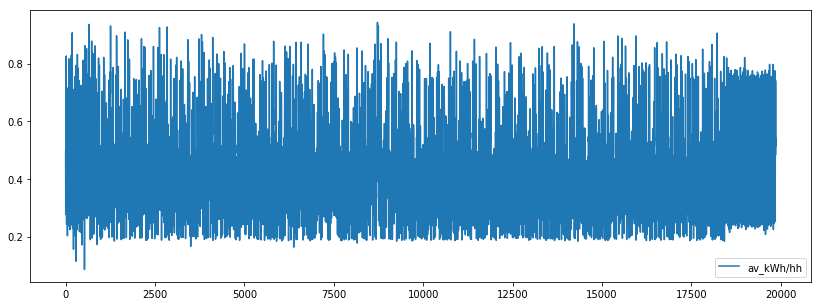

In [263]:
weather_energy.plot(y = 'av_kWh/hh', figsize = (14,5))

**Creat lag ahead scenarios**

In [264]:
#create 48 hours recency effect matrix
lag = lag_ahead_series(weather_energy.iloc[:,1:9],48,0, 8,True)


In [265]:
#create 48 housrs ahead energy consumption matrix
ahead = lag_ahead_series(weather_energy.iloc[:,10],0,49)

In [266]:
amatrix = ahead.values
lmatrix = lag.values
print(amatrix.shape)
print(lmatrix.shape)

(19803, 49)
(19803, 384)


In [267]:
merge = np.concatenate((lmatrix,amatrix),axis = 1)
scaler = MinMaxScaler(feature_range=(0, 1))
merge = scaler.fit_transform(merge)
X = merge[:,:384]
y = merge[:,384:]
X.shape, y.shape

((19803, 384), (19803, 49))

**random forest regression**

In [280]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.99, test_size = 0.01)



In [ ]:
rfr = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
rfr.fit(train_X, train_y)

In [180]:
#extact predicted values but reverse normalization first
yhat = rfr.predict(test_X)
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,384:]
#extract exact values but reverse normalization first
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,384:]



**Result evaluation**

In [181]:
#mean square error between exact and predict values
import math
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.082


In [209]:
#data preprocess
real = np.transpose(inv_y)
guess = np.transpose(inv_yhat)

real.shape, guess.shape

real = real[:12,:20]
guess = guess[:12,:20]

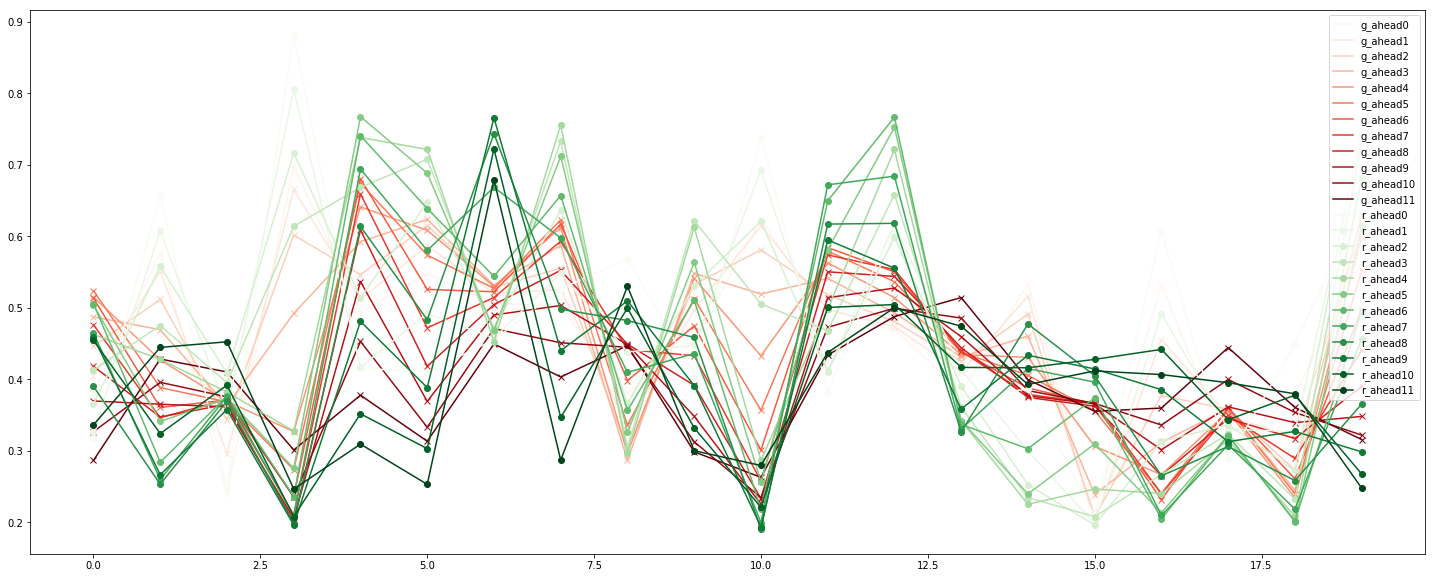

In [214]:
from matplotlib import cm
import matplotlib.pyplot as plt
rpdf = pd.DataFrame()
gpdf = pd.DataFrame()

i = 0
for row in real:
    rpdf.insert(i, "r_ahead{}".format(i), row, True) 
    i += 1

i = 0
for row in guess:
    gpdf.insert(i, "g_ahead{}".format(i), row, True) 
    i += 1
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'Reds',style='-x',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), colormap = 'Greens',style ='-o',legend = True, ax = ax)
ax.legend(frameon=False, loc='lower right', ncol=6)
#for key in gpdf:
#    gpdf['{}'.format(key)].plot(colormap = 'Greens',style='-',legend = True)
    
plt.show()

**LSTM**

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 50)             87000     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 49)             2499      
Total params: 89,499
Trainable params: 89,499
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 1s - loss: 0.1280
Epoch 2/50
 - 1s - loss: 0.0961
Epoch 3/50
 - 1s - loss: 0.0839
Epoch 4/50
 - 1s - loss: 0.0776
Epoch 5/50
 - 1s - loss: 0.0747
Epoch 6/50
 - 1s - loss: 0.0729
Epoch 7/50
 - 1s - loss: 0.0714
Epoch 8/50
 - 1s - loss: 0.0701
Epoch 9/50
 - 1s - loss: 0.0691
Epoch 10/50
 - 1s - loss: 0.0682
Epoch 11/50
 - 1s - loss: 0.0672
Epoch 12/50
 - 1s - loss: 0.0664
Epoch 13/50
 - 1s - loss: 0.0656
Epoch 14/50
 - 1s - loss: 0.0649
Epoch 15/50
 - 1s - loss: 0.0643
Epoch 16/50
 - 1s - loss: 

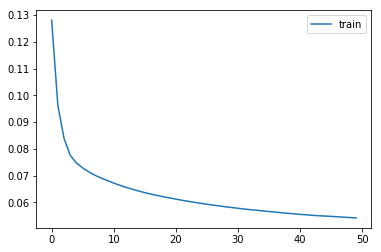

In [275]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.99, test_size = 0.01)
ltrain_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
ltest_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_y = train_y.reshape((train_y.shape[0],1, train_y.shape[1]))

from keras.layers import TimeDistributed
# design network
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(ltrain_X.shape[1], ltrain_X.shape[2]),return_sequences = True))
model.add(TimeDistributed(Dense(49)))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network
history = model.fit(ltrain_X, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [276]:
yhat = model.predict(ltest_X)
yhat = yhat.reshape(yhat.shape[0],yhat.shape[2])
ltest_X = ltest_X.reshape(ltest_X.shape[0], ltest_X.shape[2])
# invert scaling for forecast
inv_yhat = np.concatenate((ltest_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# invert scaling for actual
#ltest_y = test_y.reshape((len(test_y), 8))
inv_y = np.concatenate((ltest_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_yhat = inv_yhat[:,384:]
inv_y = inv_y[:,384:]

**performace**

import math
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [237]:
real.shape, guess.shape

((12, 199), (12, 199))

In [277]:
#data preprocess
real = np.transpose(inv_y)
guess = np.transpose(inv_yhat)

real.shape, guess.shape

real = real[:12,:14]
guess = guess[:12,:14]

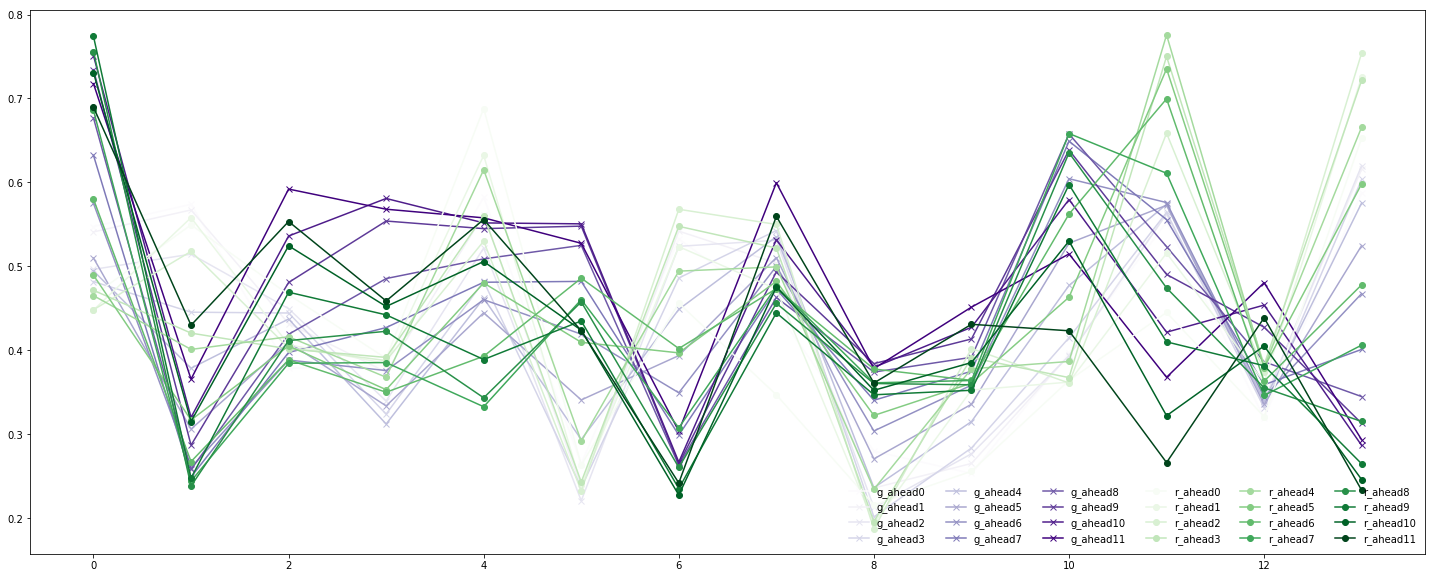

In [278]:
from matplotlib import cm
import matplotlib.pyplot as plt
rpdf = pd.DataFrame()
gpdf = pd.DataFrame()

i = 0
for row in real:
    rpdf.insert(i, "r_ahead{}".format(i), row, True) 
    i += 1

i = 0
for row in guess:
    gpdf.insert(i, "g_ahead{}".format(i), row, True) 
    i += 1
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'Purples',style='-x',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), colormap = 'Greens',style ='-o',legend = True, ax = ax)
ax.legend(frameon=False, loc='lower right', ncol=6)
#for key in gpdf:
#    gpdf['{}'.format(key)].plot(colormap = 'Greens',style='-',legend = True)
    
plt.show()

**XGBoost**

In [ ]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
xreg = xgb.XGBRegressor(max_depth = 5)
mreg = MultiOutputRegressor(xreg, n_jobs = 4)
mreg.fit(train_X, train_y)


In [271]:
#extact predicted values but reverse normalization first
yhat = mreg.predict(test_X)
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,384:]
#extract exact values but reverse normalization first
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,384:]



**Performance**


In [272]:
#data preprocess
real = np.transpose(inv_y)
guess = np.transpose(inv_yhat)

real.shape, guess.shape

real = real[:12,:14]
guess = guess[:12,:14]

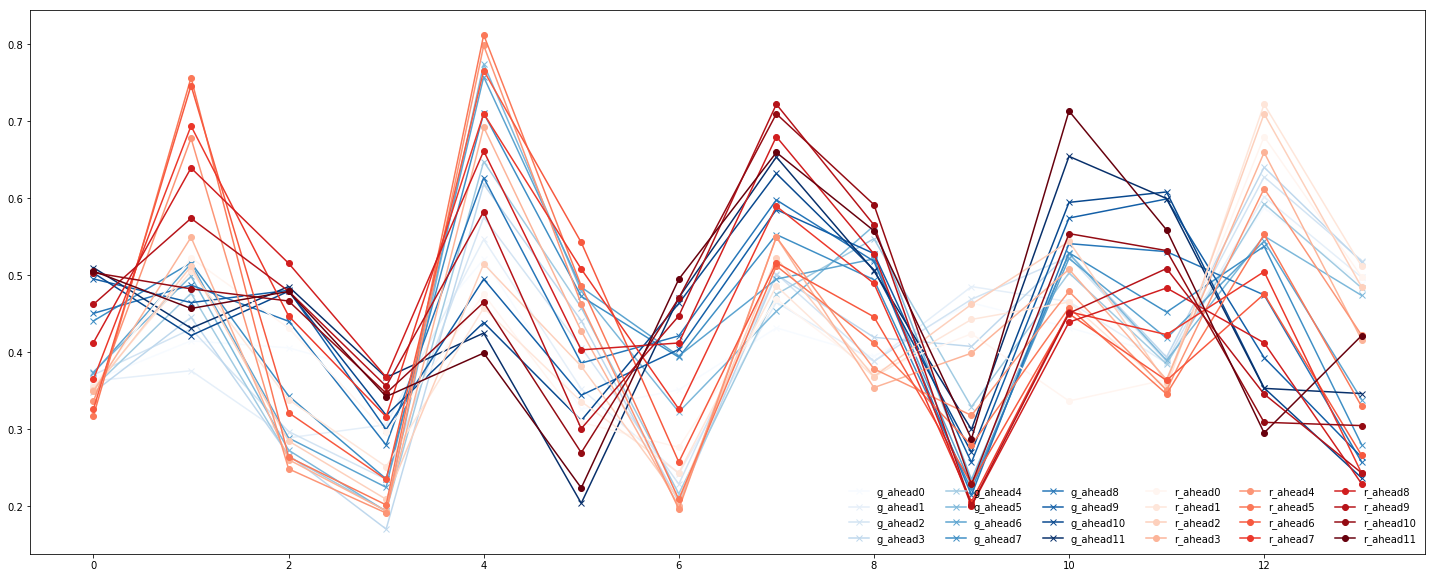

In [274]:
rpdf = pd.DataFrame()
gpdf = pd.DataFrame()

i = 0
for row in real:
    rpdf.insert(i, "real_ahead{}".format(i), row, True) 
    i += 1

i = 0
for row in guess:
    gpdf.insert(i, "guess_ahead{}".format(i), row, True) 
    i += 1
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'Blues',style='-x',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), colormap = 'Reds',style ='-o',legend = True, ax = ax)
ax.legend(frameon=False, loc='lower right', ncol=6)
#for key in gpdf:
#    gpdf['{}'.format(key)].plot(colormap = 'Greens',style='-',legend = True)
    
plt.show()